# **Advance Topics in Machine Learning**
## **Assignment 0 - Introduction**
---

### **Task 2: Understanding Vision Transformers (ViT)**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

from transformers import AutoImageProcessor, ViTForImageClassification, ViTModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Cell 3: Load pretrained ViT (ImageNet) and its processor
from transformers import ViTConfig, ViTModel

MODEL_NAME = "google/vit-base-patch16-224"

cfg = ViTConfig.from_pretrained(MODEL_NAME, output_attentions=True)  # <-- enable attentions
vit_base = ViTModel.from_pretrained(MODEL_NAME, config=cfg).to(device).eval()
patch_size = vit_base.config.patch_size

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Cell 4: Data - get a few CIFAR-10 images and a test loader for later
# (We use CIFAR-10 only as convenient images; ViT is ImageNet-pretrained.)
tf_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=tf_eval)
sample_indices = [0, 1, 2]  # pick any 1–3 images
sample_imgs = [transforms.ToPILImage()(cifar_test[i][0]) for i in sample_indices]
sample_labels = [cifar_test[i][1] for i in sample_indices]  # CIFAR-10 gt (not used for ImageNet head)

test_loader_for_eval = DataLoader(Subset(cifar_test, list(range(200))), batch_size=32, shuffle=False)
len(sample_imgs), test_loader_for_eval.dataset.__len__()

Files already downloaded and verified


(3, 200)

In [4]:
# Cell 5: Task 2.1 — Top-1 prediction for 1–3 images
def predict_top1(images_pil):
    inputs = processor(images=[img for img in images_pil], return_tensors="pt").to(device)
    with torch.no_grad():
        logits = vit_clf(**inputs).logits
        probs = torch.softmax(logits, dim=-1)
        top1 = probs.argmax(dim=-1).tolist()
        conf = probs.max(dim=-1).values.tolist()
    preds = [(id2label[i], float(c)) for i, c in zip(top1, conf)]
    return preds

preds = predict_top1(sample_imgs)
for i, (img, (label, p)) in enumerate(zip(sample_imgs, preds)):
    display(img)
    print(f"Image {i}: Top-1 = {label} ({p*100:.1f}%)")


NameError: name 'processor' is not defined

Attention map for image 0


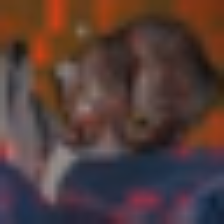

Attention map for image 1


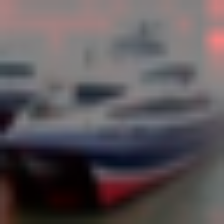

Attention map for image 2


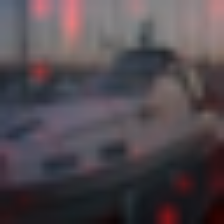

In [ ]:
# Cell 6 (fixed): Attention visualization using vit_base (now returning attentions)
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image

def attention_map_for_image(pil_img, model=vit_base, processor=processor, patch=patch_size):
    inputs = processor(images=[pil_img], return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs, return_dict=True)  # attentions enabled via config
    attns = out.attentions  # tuple/list of length = num_layers

    if attns is None:
        raise RuntimeError("Attentions are None. Ensure model was loaded with output_attentions=True.")

    # last layer attention: [B, heads, N, N], N = 1 (CLS) + num_patches
    attn_last = attns[-1]              # [B, H, N, N]
    attn_last = attn_last[0]           # [H, N, N] (take batch 0)

    # CLS (0) attention to all patch tokens (1:) → average across heads
    cls_to_patches = attn_last[:, 0, 1:]      # [H, num_patches]
    patch_attn = cls_to_patches.mean(dim=0)   # [num_patches]

    # reshape to 2D grid
    H = W = 224 // patch                      # e.g., 14
    patch_map = patch_attn.reshape(H, W)

    # normalize to [0,1]
    patch_map = (patch_map - patch_map.min()) / (patch_map.max() - patch_map.min() + 1e-6)

    # upsample to image resolution
    patch_map_t = patch_map.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
    heat = F.interpolate(
        patch_map_t,
        size=(pil_img.size[1], pil_img.size[0]),
        mode="bilinear",
        align_corners=False
    )[0, 0]
    return heat.detach().cpu().numpy()

def overlay_attention(pil_img, heat, alpha=0.45):
    # heat ∈ [0,1]; red overlay
    heat_rgb = np.zeros((heat.shape[0], heat.shape[1], 3), dtype=np.float32)
    heat_rgb[..., 0] = heat
    base = np.asarray(pil_img.resize((224,224))).astype(np.float32) / 255.0
    overlay = (1 - alpha) * base + alpha * heat_rgb
    overlay = np.clip(overlay, 0, 1)
    return Image.fromarray((overlay * 255).astype(np.uint8))

for i, img in enumerate(sample_imgs):
    heat = attention_map_for_image(img)
    vis = overlay_attention(img, heat)
    print(f"Attention map for image {i}")
    display(vis)


In [ ]:
# Cell 7: Task 2.4 — Patch masking experiments (random vs structured center masking)
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

def mask_random_patches(pil_img, mask_ratio=0.3, patch=16):
    img = pil_img.resize((224, 224)).copy()
    W, H = img.size
    gw, gh = W // patch, H // patch
    total = gw * gh
    k = int(mask_ratio * total)
    idxs = np.random.choice(total, size=k, replace=False)

    arr = np.array(img).copy()
    mean_color = arr.mean(axis=(0,1)).astype(np.uint8)

    for idx in idxs:
        y = (idx // gw) * patch
        x = (idx % gw) * patch
        arr[y:y+patch, x:x+patch] = mean_color
    return Image.fromarray(arr)

def mask_center(pil_img, center_ratio=0.5):
    img = pil_img.resize((224, 224)).copy()
    W, H = img.size
    cw, ch = int(W * center_ratio), int(H * center_ratio)
    x0 = (W - cw) // 2
    y0 = (H - ch) // 2

    arr = np.array(img).copy()
    mean_color = arr.mean(axis=(0,1)).astype(np.uint8)
    arr[y0:y0+ch, x0:x0+cw] = mean_color
    return Image.fromarray(arr)

def accuracy_with_mask(dataloader, mask_fn=None, **mask_kwargs):
    """
    Self-consistency accuracy: compare masked predictions vs unmasked predictions
    (since CIFAR-10 labels don't match ImageNet classes of the ViT head).
    """
    correct, total = 0, 0
    for x, _ in dataloader:
        imgs_nomask = [transforms.ToPILImage()(img) for img in x]
        if mask_fn is None:
            imgs_masked = imgs_nomask
        else:
            imgs_masked = [mask_fn(img, **mask_kwargs) for img in imgs_nomask]

        with torch.no_grad():
            ref_inputs = processor(images=imgs_nomask, return_tensors="pt").to(device)
            ref_logits = vit_clf(**ref_inputs).logits
            ref_pred = ref_logits.argmax(dim=-1).cpu().numpy()

            m_inputs = processor(images=imgs_masked, return_tensors="pt").to(device)
            m_logits = vit_clf(**m_inputs).logits
            m_pred = m_logits.argmax(dim=-1).cpu().numpy()

        correct += (ref_pred == m_pred).sum()
        total += len(imgs_nomask)
    return correct / total

# Small subset for speed
subset = Subset(cifar_test, list(range(100)))
loader_small = DataLoader(subset, batch_size=16, shuffle=False)

acc_nomask = accuracy_with_mask(loader_small, mask_fn=None)
acc_rand30 = accuracy_with_mask(loader_small, mask_fn=mask_random_patches, mask_ratio=0.30)
acc_center50 = accuracy_with_mask(loader_small, mask_fn=mask_center, center_ratio=0.5)

acc_nomask, acc_rand30, acc_center50


(np.float64(1.0), np.float64(0.59), np.float64(0.23))

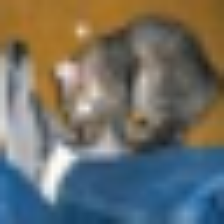

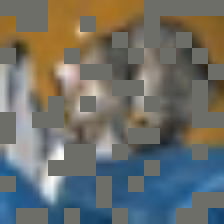

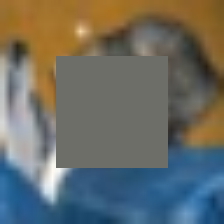

In [ ]:
# Cell 8: Visual check of masking on one image
test_img = sample_imgs[0]
display(test_img.resize((224,224)))
display(mask_random_patches(test_img, mask_ratio=0.3))
display(mask_center(test_img, center_ratio=0.5))


In [ ]:
# Cell 9: Task 2.5 — Linear probes on CLS vs mean patch tokens (on CIFAR-10 subset)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train_subset = Subset(datasets.CIFAR10(root="./data", train=True, download=True, transform=tf_eval),
                      list(range(2000)))  # small for speed
val_subset = Subset(cifar_test, list(range(1000)))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

def extract_features_and_labels(loader):
    X_cls, X_mean, Y = [], [], []
    for x, y in loader:
        imgs = [transforms.ToPILImage()(img) for img in x]
        inputs = processor(images=imgs, return_tensors="pt").to(device)
        with torch.no_grad():
            outs = vit_base(**inputs, return_dict=True)  # vit_base returns last_hidden_state
            last = outs.last_hidden_state  # [B, N, D], N=1+patches
            cls = last[:, 0, :]            # [B, D]
            mean_patches = last[:, 1:, :].mean(dim=1)  # [B, D]
        X_cls.append(cls.cpu())
        X_mean.append(mean_patches.cpu())
        Y.append(y)
    X_cls = torch.cat(X_cls).numpy()
    X_mean = torch.cat(X_mean).numpy()
    Y = torch.cat(Y).numpy()
    return X_cls, X_mean, Y

Xtr_cls, Xtr_mean, Ytr = extract_features_and_labels(train_loader)
Xva_cls, Xva_mean, Yva = extract_features_and_labels(val_loader)

clf_cls = LogisticRegression(max_iter=2000, n_jobs=-1)
clf_mean = LogisticRegression(max_iter=2000, n_jobs=-1)

clf_cls.fit(Xtr_cls, Ytr)
clf_mean.fit(Xtr_mean, Ytr)

pred_cls = clf_cls.predict(Xva_cls)
pred_mean = clf_mean.predict(Xva_mean)

acc_cls = accuracy_score(Yva, pred_cls)
acc_mean = accuracy_score(Yva, pred_mean)

acc_cls, acc_mean


Files already downloaded and verified


(0.961, 0.961)

In [ ]:
# ...existing code...
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Subset

# choose classes to show
chosen_classes = ['airplane', 'automobile', 'cat', 'dog', 'frog']  # change if you prefer ship/truck etc.

# find one example index per class in cifar_test
class_to_idx = {name: i for i, name in enumerate(cifar_test.classes)}
picked_indices = []
for cls in chosen_classes:
    target_label = class_to_idx[cls]
    for idx in range(len(cifar_test)):
        if cifar_test[idx][1] == target_label:
            picked_indices.append(idx)
            break

# load images
imgs = [transforms.ToPILImage()(cifar_test[i][0]) for i in picked_indices]

# produce overlays
overlays = []
for img in imgs:
    heat = attention_map_for_image(img)      # uses vit_base + processor as defined earlier
    overlays.append(overlay_attention(img, heat))

# plot and save
plt.figure(figsize=(15, 6))
for i, (orig, ov, cls) in enumerate(zip(imgs, overlays, chosen_classes)):
    ax = plt.subplot(2, len(imgs), i + 1)
    ax.imshow(orig.resize((224,224))); ax.axis('off'); ax.set_title(f'{cls} (orig)')
    ax2 = plt.subplot(2, len(imgs), len(imgs) + i + 1)
    ax2.imshow(ov); ax2.axis('off'); ax2.set_title(f'{cls} (CLS-attn overlay)')
plt.tight_layout()
Path("outputs").mkdir(exist_ok=True)
plt.savefig("outputs/attention_figure5.png", dpi=200)
plt.show()

In [ ]:
# Cell 10: Quick summary dictionary of key metrics
summary = {
    "Self-consistency acc (no mask)": acc_nomask,
    "Self-consistency acc (random 30% masked)": acc_rand30,
    "Self-consistency acc (center 50% masked)": acc_center50,
    "Linear probe acc (CLS token)": acc_cls,
    "Linear probe acc (mean of patch tokens)": acc_mean,
}
summary


{'Self-consistency acc (no mask)': np.float64(1.0),
 'Self-consistency acc (random 30% masked)': np.float64(0.59),
 'Self-consistency acc (center 50% masked)': np.float64(0.23),
 'Linear probe acc (CLS token)': 0.961,
 'Linear probe acc (mean of patch tokens)': 0.961}